# Insect Recognizer

## Introduction

This notebook is the starting point for insect recognizer.

## Data Importing

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "dataset/train"
val_dir = "dataset/valid"

train_datagen = ImageDataGenerator(
    rescale=1./255,       # normalize pixel values
    rotation_range=20,    # small random rotation
    zoom_range=0.2,       # small random zoom
    horizontal_flip=True  # flip image horizontally
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),   # resize all images
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 14700 images belonging to 27 classes.
Found 4200 images belonging to 27 classes.


## Data Understanding

### Classes

In [5]:
# Check the class labels detected by the generator
print("Class indices:", train_generator.class_indices)

# Reverse dictionary (to map index -> class name)
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

Class indices: {'ant': 0, 'bee': 1, 'bee_apis': 2, 'bee_bombus': 3, 'beetle': 4, 'beetle_cocci': 5, 'beetle_oedem': 6, 'bug': 7, 'bug_grapho': 8, 'fly': 9, 'fly_empi': 10, 'fly_sarco': 11, 'fly_small': 12, 'hfly_episyr': 13, 'hfly_eristal': 14, 'hfly_eupeo': 15, 'hfly_myathr': 16, 'hfly_sphaero': 17, 'hfly_syrphus': 18, 'lepi': 19, 'none_bg': 20, 'none_bird': 21, 'none_dirt': 22, 'none_shadow': 23, 'other': 24, 'scorpionfly': 25, 'wasp': 26}
Class labels: ['ant', 'bee', 'bee_apis', 'bee_bombus', 'beetle', 'beetle_cocci', 'beetle_oedem', 'bug', 'bug_grapho', 'fly', 'fly_empi', 'fly_sarco', 'fly_small', 'hfly_episyr', 'hfly_eristal', 'hfly_eupeo', 'hfly_myathr', 'hfly_sphaero', 'hfly_syrphus', 'lepi', 'none_bg', 'none_bird', 'none_dirt', 'none_shadow', 'other', 'scorpionfly', 'wasp']


### Number of Images

In [6]:
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)

Number of training samples: 14700
Number of validation samples: 4200


### Some Images

In [21]:
### TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST ###

import os
import json

# directory for test files
test_dir = "test_labels"
os.makedirs(test_dir, exist_ok=True)

# example .txt files
example_files = {
    "file1.txt": [
        "7541 0.60969 0.34226 0.04449 0.08179\n",
        "1234 0.77409 0.82476 0.00944 0.03344\n",
        "11077 0.92703 0.98782 0.01512 0.02436\n"
    ],
    "file2.txt": [
        "5678 0.12345 0.23456 0.34567 0.45678\n",
        "11431 0.98765 0.87654 0.76543 0.65432\n"
    ]
}

for fname, lines in example_files.items():
    with open(os.path.join(test_dir, fname), "w") as f:
        f.writelines(lines)

# example .json file
notes_data = [
    {"id": 0, "name": "Abablemma discipuncta", "rank": "SPECIES"},
    {"id": 1, "name": "Abablemma grandimacula", "rank": "SPECIES"},
    {"id": 2, "name": "Abablemma sp.", "rank": "GENUS"},
    {"id": 3, "name": "Abablemma ulopus", "rank": "SPECIES"},
    {"id": 7541, "name": "Abablemma testid", "rank": "GENUS"}
]

notes_file = os.path.join(test_dir, "notes.json")
with open(notes_file, "w") as f:
    json.dump(notes_data, f, indent=4)
print("Test files are succesfully made:")
print(os.listdir(test_dir))


### TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST ###

Test files are succesfully made:
['file2.txt', 'file1.txt', 'notes.json', '.ipynb_checkpoints']


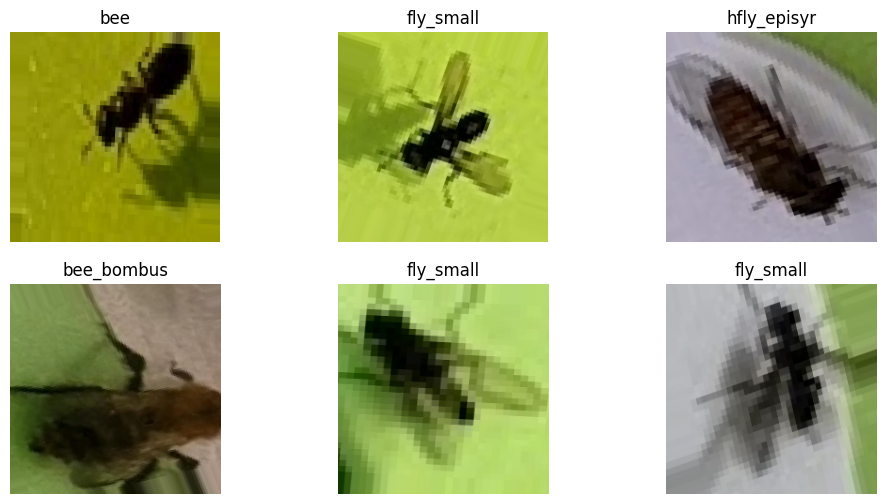

In [7]:
import matplotlib.pyplot as plt

# Get one batch of images and labels
images, labels = next(train_generator)

# Show first 6 images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].argmax()])  # get class name
    plt.axis("off")
plt.show()


### Class Distribution

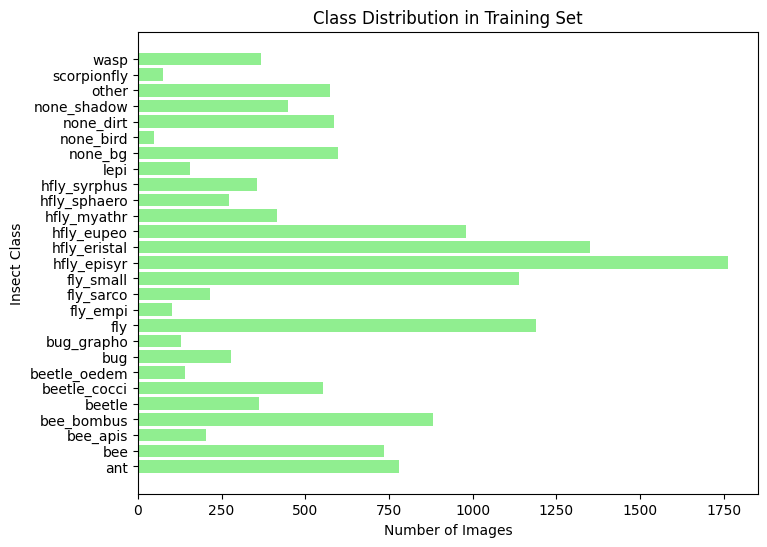

In [9]:
import numpy as np

# Count number of samples for each class in training set
train_counts = np.bincount(train_generator.classes)

# Plot horizontal bar chart
plt.figure(figsize=(8,6))   # bigger figure
plt.barh(class_labels, train_counts, color="lightgreen")
plt.xlabel("Number of Images")
plt.ylabel("Insect Class")
plt.title("Class Distribution in Training Set")
plt.show()


In [1]:
import os
import json

# function for .txt files
def remove_lines_with_ids(labels_dir, bad_ids):
    removed_total = 0
    for filename in os.listdir(labels_dir):
        if filename.endswith(".txt"):
            file_path = os.path.join(labels_dir, filename)
            with open(file_path, "r") as f:
                lines = f.readlines()
            
            new_lines = []
            removed_count = 0
            for line in lines:
                if any(bad_id in line.split() for bad_id in bad_ids):
                    removed_count += 1
                else:
                    new_lines.append(line)
            
            with open(file_path, "w") as f:
                f.writelines(new_lines)
            
            if removed_count > 0:
                print(f"  {removed_count} lines deleted in {filename}")
                removed_total += removed_count
    
    print(f"\ndone, a total of {removed_total} lines are deleted throughout all files")


# function for .json file
def remove_ids_from_json(json_file, bad_ids):
    """
    deletes objects with specific IDs from a flat json list
    """
    with open(json_file, "r") as f:
        data = json.load(f)
    
    if isinstance(data, list):
        original_count = len(data)
        data = [item for item in data if str(item.get("id")) not in bad_ids]
        removed_count = original_count - len(data)
        print(f"  {removed_count} lines deleted in {json_file}")
    else:
        print(f"  {json_file} does not contain a list but {type(data)}, no changes applied")
        return
    
    with open(json_file, "w") as f:
        json.dump(data, f, indent=4)

# use of the function
labels_dir = "dataset/ami_traps/ami_traps_dataset/labels"
notes_json_file = "dataset/ami_traps/ami_traps_dataset/notes.json"
bad_ids = {"11077", "11431", "7541"}

# filtering of the .txt files
remove_lines_with_ids(labels_dir, bad_ids)

# filtering of the .json file
remove_ids_from_json(notes_json_file, bad_ids)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/ami_traps/ami_traps_dataset/labels'